### loading the model

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import asyncio

from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Load environment variables
load_dotenv()

# Initialize the chat model globally so it's reused across calls
llm = ChatGroq(temperature=0, model_name="llama-3.1-8b-instant")


In [87]:
result = llm.invoke("Write a ballad about LangChain")
print(result.content)

(Verse 1)
In realms of code, where minds entwine,
A new creation rose, a work divine.
LangChain, a name that echoes through time,
A tool of wonder, born of human design.

(Chorus)
Oh LangChain, with chains of thought so fine,
You weave a tapestry of language and mind.
A bridge between the human and the machine,
A symphony of words, a harmony serene.

(Verse 2)
With LLaMA's power, and Chain's gentle might,
You bring forth answers, in the dark of night.
A conversational AI, with wit and guile,
You converse with humans, with a gentle smile.

(Chorus)
Oh LangChain, with chains of thought so fine,
You weave a tapestry of language and mind.
A bridge between the human and the machine,
A symphony of words, a harmony serene.

(Bridge)
In the realm of knowledge, you roam so free,
A wanderer of wisdom, with a heart full of glee.
You gather facts, and weave them into a tale,
A narrative of wonder, that never will fail.

(Verse 3)
With Chain's versatility, and LLaMA's flair,
You adapt to tasks, wit

### Let's Create a Retriever now

In [30]:
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

# 1. Load PDFs from local folder
pdf_folder = "./docs"  # Path to your PDFs
loader = DirectoryLoader(
    pdf_folder,
    glob="**/*.pdf",
    loader_cls=PyPDFLoader,
    show_progress=True
)
docs_list = loader.load()

# 2. Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250,
    chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# 3. Create FAISS vector store
vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=embeddings
)

# 6. Create retriever
retriever = vectorstore.as_retriever()
print("FAISS vector store created successfully!")



100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


FAISS vector store created successfully!


### Lets Create a RAG Chain Now

In [31]:

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

print(f"---PROMPT--- {prompt}")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

e:\Projects\ragInvestor\venv\Lib\site-packages\langsmith\client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


---PROMPT--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


### Let's test the RAG Chain Now

In [34]:
# Run

question = "tell me about attention"
docs = retriever.get_relevant_documents(question)

generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Attention is a function that maps a query and a set of key-value pairs to an output, where the output is a weighted sum of the values. The weights are computed by a compatibility function of the query with the corresponding key. This function is used in the Transformer model to focus on relevant parts of the input sequence.


### Now lets create grade document class

In [35]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

e:\Projects\ragInvestor\venv\Lib\site-packages\IPython\core\interactiveshell.py:3549: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [37]:
question = "tell me about the agent memory."
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [38]:
question = "tell me about attention."
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### Let's Create Question Re-Writer

In [39]:
### Question Re-writer
# Prompt
from langchain_core.prompts import ChatPromptTemplate

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
     
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [40]:
question_rewriter.invoke({"question": question})

'Here\'s an improved version of the question:\n\n"What is attention, and how does it work in cognitive psychology and neuroscience?"\n\nThis revised question is more specific and includes relevant keywords that can help with web search. It also breaks down the topic into two main areas: cognitive psychology and neuroscience, which can lead to more targeted and relevant results.\n\nAlternatively, you could also ask:\n\n* "What is the definition of attention in psychology?"\n* "How does attention affect cognitive processing?"\n* "What are the different types of attention in cognitive psychology?"\n* "What is the neural basis of attention?"\n\nEach of these questions targets a specific aspect of the topic and can lead to more focused and relevant search results.'

### Lets create a required function

In [41]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
    
    """
    print("---RETRIEVE---")
    
    question = state["question"]
    
    documents = retriever.get_relevant_documents(question)
    
    return {"documents": documents, "question": question}

In [42]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    
    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    
    web_search = "No"
    
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [43]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")
    
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    
    return {"documents": documents, "question": question, "generation": generation}

In [44]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    
    question = state["question"]
    
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    
    return {"documents": documents, "question": better_question}

### Web Crawling we gonna perform using WikiPedia

In [61]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

# Initialize Wikipedia tool
web_search_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=3))

# Example usage
result = web_search_tool.run("large language models")
print(result)

Page: Large language model
Summary: A large language model (LLM) is a type of machine learning model designed for natural language processing tasks such as language generation. LLMs are language models with many parameters, and are trained with self-supervised learning on a vast amount of text.
The largest and most capable LLMs are generative pretrained transformers (GPTs). Modern models can be fine-tuned for specific tasks or guided by prompt engineering. These models acquire predictive power regarding syntax, semantics, and ontologies inherent in human language corpora, but they also inherit inaccuracies and biases present in the data they are trained in.



Page: List of large language models
Summary: A large language model (LLM) is a type of machine learning model designed for natural language processing tasks such as language generation. LLMs are language models with many parameters, and are trained with self-supervised learning on a vast amount of text.
This page lists notable la

In [73]:

from langchain.schema import Document
def web_search(state):
    """
    Wikipedia search based on the re-phrased question.

    Args:
        state (dict): The current graph state
            - "question": str
            - "documents": list[Document]

    Returns:
        state (dict): Updated state with appended Wikipedia results
    """
    print("---WIKIPEDIA SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Wikipedia search
    wiki_content = web_search_tool.run(question)
    
    # Create a single document with all results
    web_results = Document(
        page_content=wiki_content,
        metadata={"source": "wikipedia"}
    )
    
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [74]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Let's create a skeleton of code then will create the function accordingly

In [75]:
from langgraph.graph import END, StateGraph, START

In [76]:
from typing import List

from typing_extensions import TypedDict

class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

workflow= StateGraph(State)

In [77]:
# define the nodes
# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

In [78]:
# Build graph
workflow.add_edge(START, "retrieve")

workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges("grade_documents", decide_to_generate, {"transform_query": "transform_query","generate": "generate",}),

workflow.add_edge("transform_query", "web_search_node")

workflow.add_edge("web_search_node", "generate")

workflow.add_edge("generate", END)

In [79]:
# Compile
app = workflow.compile()

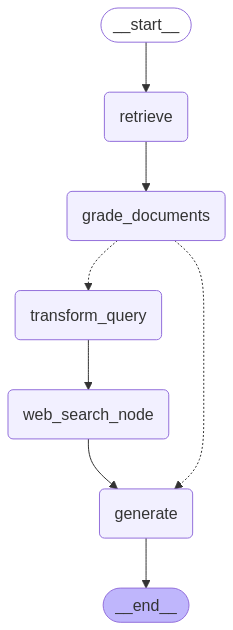

In [80]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [81]:
from pprint import pprint

# Run
inputs = {"question": "tell me about the agent memory."}

In [82]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WIKIPEDIA SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('In artificial intelligence, agent memory refers to the ability of an agent '
 'to store and retrieve information about its environment, actions, and '
 'outcomes. This concept is crucial for decision-making and learning in '
 'complex situations. Agent memory can be implemented using various '
 'techniques, such as neural networks or knowledge graphs.')


In [83]:
from pprint import pprint

# Run
inputs = {"question": "tell me about the taj mahal."}

In [33]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The Taj Mahal, commissioned in 1632 by Mughal emperor Shah Jahan, is a '
 'mausoleum for his wife Mumtaz Mahal.  Construction took 22 years and '
 'incorporated white marble inlaid with semi-precious stones.  Its '
 'significance lies in its architectural grandeur, symbolic representation of '
 'love and power, and status as a globally recognized symbol of India.\n')
